In [94]:
import skimage.io as sio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import diff_classifier.aws as aws
from skimage.filters import roberts, sobel, scharr, prewitt, median, rank
from skimage import img_as_ubyte
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, disk, reconstruction
#from skimage.transform import EuclideanTransform
from scipy.ndimage.morphology import distance_transform_edt as EuclideanTransform
import diff_register.im_process as imp

In [2]:
to_track = []
result_futures = {}

remote_folder = 'Cell_Studies/10_16_18_cell_study' #Folder in AWS S3 containing files to be analyzed
bucket = 'ccurtis.data'
vids = 5
types = ['PS', 'PEG']
slices = [1, 2]

for typ in types:
    for slic in slices:
        for num in range(1, vids+1):
            #to_track.append('100x_0_4_1_2_gel_{}_bulk_vid_{}'.format(vis, num))
            to_track.append('{}_{}_XY{}'.format(typ, slic, num))

In [12]:
track = to_track[10:11][0]
filename = 'features_{}.csv'.format(track)
#aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name=bucket)
fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')

In [40]:
bfilename = 'bi_BF_cells_{}.tif'.format(track)
longname = remote_folder+'/'+bfilename
#aws.download_s3(longname, bfilename, bucket_name=bucket)
bfimage = plt.imread(bfilename)[:, :, 0] > 70

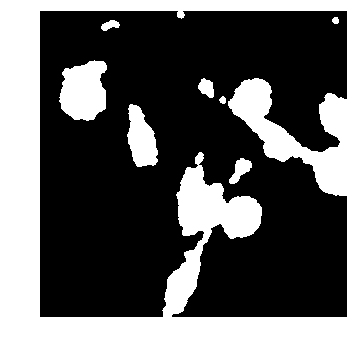

In [41]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(bfimage, cmap='gray')
ax.axis('off')
fig.tight_layout()

In [42]:
[bfimage[int(fstats.Y[i]-1), int(fstats.X[i])-1] for i in range(len(fstats.X))]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [89]:
dist = [0]*len(fstats.X)

for i in range(len(fstats.X)):
    mid = bfimage[int(fstats.Y[i]-1), int(fstats.X[i])-1]
    for j in range(1,2000):
        lo = np.array([int(fstats.Y[i]-1-j), int(fstats.X[i])-1-j])
        lo[lo < 0] = 0
        hi = np.array([int(fstats.Y[i]-1)+j+1, int(fstats.X[i])-1+j+1])
        area = bfimage[lo[0]:hi[0], lo[1]:hi[1]] == mid
        if np.mean(area) < 1:
            dist[i] = j
            break

KeyboardInterrupt: 

In [104]:
euimage = EuclideanTransform(bfimage)+EuclideanTransform(~bfimage)

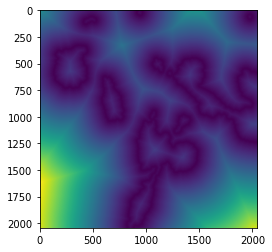

In [105]:
plt.imshow(euimage)

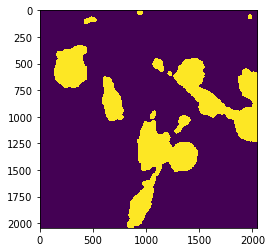

In [107]:
plt.imshow(bfimage)

In [110]:
euimage = EuclideanTransform(bfimage)+EuclideanTransform(~bfimage)
dist = [int(euimage[int(fstats.Y[i]-1), int(fstats.X[i])-1]) for i in range(len(fstats.X))]

In [121]:
filename = 'msd_{}.csv'.format(track)
aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name=bucket)
msds = pd.read_csv(filename, encoding = "ISO-8859-1")

In [135]:
msds_cell_status = [bfimage[2043, int(msds.X[i])-1] if msds.Y[i]>2044 else bfimage[int(msds.Y[i]-1), int(msds.X[i])-1]
                    if msds.Y[i]>0  else np.nan for i in range(len(msds.X))]

In [136]:
msds['Cell Status'] = msds_cell_status

In [138]:
msds.head()

,Unnamed: 0,Frame,Track_ID,X,Y,MSDs,Gauss,Quality,SN_Ratio,Mean_Intensity,Cell Status
0,0,0.0,0.0,276.468992,1805.369978,0.000000,0.000000,32.244995,1.030455,598.525773,False
1,1,1.0,0.0,277.729969,1806.510688,25.515191,0.770219,32.120667,1.036724,595.835052,False
2,2,2.0,0.0,276.747745,1808.946209,57.857519,0.716655,30.688049,0.962570,587.206186,False
3,3,3.0,0.0,275.192004,1808.026153,98.231407,0.639853,36.104675,0.989967,590.670103,False
4,4,4.0,0.0,279.245776,1807.371126,130.880457,0.657416,32.198242,1.025258,596.247423,False


In [144]:
subcell_status = msds[msds.Track_ID == 4]['Cell Status'].dropna()

In [150]:
cross = np.sum(np.diff(subcell_status) == True)

In [152]:
msds_distance = [euimage[2043, int(msds.X[i])-1] if msds.Y[i]>2044 else euimage[int(msds.Y[i]-1), int(msds.X[i])-1]
                 if msds.Y[i]>0  else np.nan for i in range(len(msds.X))]

In [154]:
msds['Cell Distance'] = msds_distance

In [175]:
subcell_distance = msds[msds.Track_ID == 4]['Cell Distance'].dropna()

In [180]:
np.mean(np.diff(subcell_distance) > 0)

0.59375

In [177]:
np.sum(np.diff(subcell_distance))

8.2475217528212852

In [223]:
def BF_cell_features(prefix, folder, bucket='ccurtis.data'):
    
    ffilename = 'features_{}.csv'.format(prefix)
    mfilename = 'msd_{}.csv'.format(prefix)
    bffilename = 'BF_cells_{}.tif'.format(prefix)
    biim = 'bi_BF_cells_{}.tif'.format(prefix)
    
    aws.download_s3('{}/{}'.format(folder, ffilename), ffilename, bucket_name=bucket)
    aws.download_s3('{}/{}'.format(folder, mfilename), mfilename, bucket_name=bucket)
    aws.download_s3('{}/{}'.format(folder, bffilename), bffilename, bucket_name=bucket)
    print('Successfully downloaded files')
    
    fstats = pd.read_csv(ffilename, encoding = "ISO-8859-1")
    msds = pd.read_csv(mfilename, encoding = "ISO-8859-1")
    bfimage = plt.imread(bffilename)
    tophimage = binary_BF(bfimage, opense=disk(12), bi_thresh=1.2, tophatse=disk(20))
    euimage = EuclideanTransform(tophimage)+EuclideanTransform(~tophimage)
    print('Successfully performed image processing')
    
    fstats['Cell Status'] = [tophimage[2043, int(fstats.X[i])-1] if fstats.Y[i]>2044
                             else tophimage[int(fstats.Y[i]-1), int(fstats.X[i])-1] if fstats.Y[i]>0
                             else np.nan for i in range(len(fstats.X))]
    fstats['Cell Distance'] = [int(euimage[2043, int(fstats.X[i])-1]) if fstats.Y[i]>2044
                               else int(euimage[int(fstats.Y[i]-1), int(fstats.X[i])-1]) if fstats.Y[i]>0
                               else np.nan for i in range(len(fstats.X))]
    print('Successfully calculated Cell Status Params')
    
    msds['Cell Status'] = [tophimage[2043, int(msds.X[i])-1] if msds.Y[i]>2044
                           else tophimage[int(msds.Y[i]-1), int(msds.X[i])-1] if msds.Y[i]>0 
                           else np.nan for i in range(len(msds.X))]
    msds['Cell Distance'] = [euimage[2043, int(msds.X[i])-1] if msds.Y[i]>2044
                             else euimage[int(msds.Y[i]-1), int(msds.X[i])-1] if msds.Y[i]>0  
                             else np.nan for i in range(len(msds.X))]
    
    
    fstats['Membrane Xing'] = [np.sum(np.diff(msds[msds.Track_ID == i]['Cell Status'].dropna()) == True) for i in range(len(fstats.X))]
    fstats['Distance Towards Cell'] = [np.sum(np.diff(msds[msds.Track_ID == i]['Cell Distance'].dropna())) for i in range(len(fstats.X))]
    fstats['Percent Towards Cell'] = [np.mean(np.diff(msds[msds.Track_ID == i]['Cell Distance'].dropna()) > 0) for i in range(len(fstats.X))]
    print('Successfully calculated Membrane Xing Params')
    
    fstats.to_csv(ffilename, sep=',', encoding = "ISO-8859-1")
    msds.to_csv(mfilename, sep=',', encoding = "ISO-8859-1")
    plt.imsave(biim, tophimage, cmap='gray')
    
    aws.upload_s3(ffilename, '{}/{}'.format(folder, ffilename), bucket_name=bucket)
    aws.upload_s3(mfilename, '{}/{}'.format(folder, mfilename), bucket_name=bucket)
    aws.upload_s3(biim, '{}/{}'.format(folder, biim), bucket_name=bucket)
    print('Successfully uploaded files')
    
    return fstats

Successfully downloaded files


/home/ubuntu/miniconda3/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 11 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


Successfully performed image processing
Successfully calculated Cell Status Params
Successfully calculated Membrane Xing Params
Successfully uploaded files


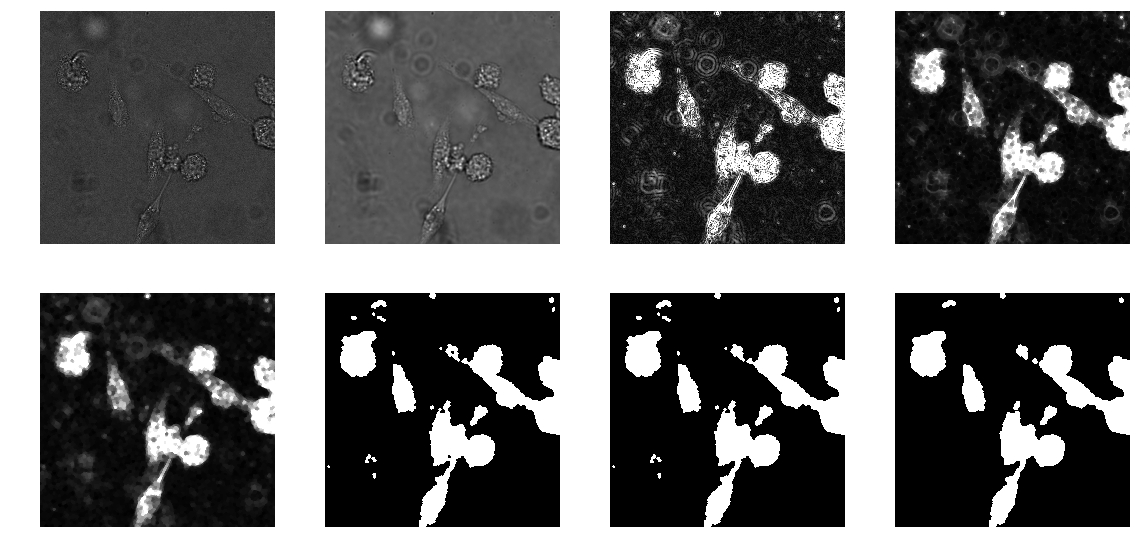

In [224]:
fstats = BF_cell_features(to_track[10], remote_folder, bucket) 

In [227]:
fstats[fstats['Membrane Xing']>0].shape

(1115, 73)

In [228]:
fstats[fstats['Membrane Xing']>0]

,Unnamed: 0,Track_ID,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,...,Std SN_Ratio,Mean Deff1,Std Deff1,Mean Deff2,Std Deff2,Cell Status,Cell Distance,Membrane Xing,Distance Towards Cell,Percent Towards Cell
996,996,996.0,0.917087,2.292581e+01,1.681439,0.942038,0.122173,0.365229,2.036246,0.508900,...,0.199932,7.173587,3.969119,4.649493,0.000000,False,15,2,-2.101289e+01,0.400000
1003,1003,1003.0,0.614901,1.489351e+01,2.080274,0.583479,0.365893,0.114021,1.275658,0.216091,...,0.164262,6.233752,3.544871,2.937877,0.000000,True,9,1,-1.123106e+00,0.545455
1018,1018,1018.0,1.900799,7.841533e-01,1.604447,0.726777,0.282161,0.170462,1.252755,0.201759,...,0.196848,7.714423,4.758705,1.412627,0.232518,True,19,1,-3.958204e+01,0.435897
1019,1019,1019.0,9.032743,2.947509e-13,2.163740,0.870530,0.186143,0.268392,2.304184,0.566007,...,0.198155,6.981565,3.829179,6.192064,5.027368,False,5,9,7.564754e+00,0.428571
1037,1037,1037.0,0.748242,6.124772e+00,1.791999,0.713890,0.289927,0.164299,1.449507,0.310110,...,0.135291,8.270162,4.068340,4.695714,2.605326,True,2,7,-1.136540e+01,0.296296
1038,1038,1038.0,0.059598,7.254826e+01,3.101911,0.806725,0.231607,0.216444,1.721220,0.419017,...,0.196848,7.714423,4.758705,1.412627,0.232518,False,24,2,-7.767458e+00,0.434783
1046,1046,1046.0,0.831457,1.357736e+01,1.624956,0.953432,0.109185,0.389354,2.208464,0.547197,...,0.164262,6.233752,3.544871,2.937877,0.000000,True,12,4,-1.793864e+01,0.461538
1048,1048,1048.0,1.420572,3.042273e+00,2.001266,0.940942,0.123359,0.363114,2.391760,0.581898,...,0.161005,8.086306,4.285290,0.758866,0.000000,True,14,2,1.133722e+01,0.515152
1050,1050,1050.0,0.419592,1.761035e+01,2.175575,0.475106,0.428878,0.083251,1.870892,0.465496,...,0.164262,6.233752,3.544871,2.937877,0.000000,False,5,1,2.605551e+00,0.434783
1052,1052,1052.0,1.590375,2.214378e+00,1.618067,0.990389,0.049136,0.528849,3.079445,0.675266,...,0.184262,7.023913,3.482508,19.752119,15.251418,False,16,3,-2.167721e-01,0.500000


In [ ]:
for track in to_track[10:]:
    filename = 'features_{}.csv'.format(track)
    aws.download_s3('{}/{}'.format(folder, filename), filename, bucket_name=bucket)
    fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
    
    bfilename = 'BF_cells_{}.tif'.format(track)
    longname = folder+'/'+bfilename
    aws.download_s3(longname, bfilename, bucket_name=bucket)
    bfimage3 = plt.imread(bfilename)
    tophim = binary_BF(bfimage3, opense=disk(12), bi_thresh=1.2, tophatse=disk(20))
    biim = 'bi_BF_cells_{}.tif'.format(track)
    plt.imsave(biim, tophim)
    aws.upload_s3(biim, '{}/{}'.format(folder, biim), bucket_name=bucket)
    
    #fstats['Cell Status'] = [tophim[int(fstats.Y[i]-1), int(fstats.X[i])-1] for i in range(len(fstats.X))]
    #fstats.to_csv(filename, sep=',', encoding = "ISO-8859-1")
    #aws.upload_s3(filename, '{}/{}'.format(folder, filename), bucket_name=bucket)
    
    #fig, ax = plt.subplots(figsize=(12,12))
    #ax.imshow(bfimage3, cmap='gray')
    #ax.scatter(fstats.X.values, fstats.Y.values, s=10, c=fstats['Cell Status'])
    #ax.axis('off')
    #overim = 'ov_BF_cells_{}.png'.format(track)
    #plt.savefig(overim)
    #aws.upload_s3(overim, '{}/{}'.format(folder, overim), bucket_name=bucket)

In [193]:
def binary_BF(image, meanse=disk(10), edgefilt='prewitt', opense=disk(10),
          fill_first=False, bi_thresh=0.000025, tophatse=disk(20)):
    
    #convertim = img_as_ubyte(image)
    meanim = rank.mean(image, meanse)
    if edgefilt is 'prewitt':
        edgeim = prewitt(meanim)
    elif edgefilt is 'sobel':
        edgeim = sobel(meanim)
    elif edgefilt is 'scharr':
        edgeim = scharr(meanim)
    elif edgefilt is 'roberts':
        edgeim = roberts(meanim)
    
    closeim = closing(edgeim, opense)
    openim = opening(closeim, opense)
    if fill_first:
        seed = np.copy(openim)
        seed[1:-1, 1:-1] = openim.max()
        mask = openim
        filledim = reconstruction(seed, mask, method='erosion')
        binarim = filledim > bi_thresh
    else:
        binarim = openim > bi_thresh*np.mean(openim)
        seed = np.copy(binarim)
        seed[1:-1, 1:-1] = binarim.max()
        mask = binarim
        filledim = reconstruction(seed, mask, method='erosion')

    tophim = filledim - closing(white_tophat(filledim, tophatse), opense)>0.01

    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
    ax[0][0].imshow(image, cmap='gray')
    ax[0][1].imshow(meanim, cmap='gray')
    ax[0][2].imshow(edgeim, cmap='gray', vmax=4*np.mean(edgeim))
    ax[0][3].imshow(closeim, cmap='gray', vmax=4*np.mean(closeim))
    ax[1][0].imshow(openim, cmap='gray', vmax=4*np.mean(openim))
    ax[1][1].imshow(binarim, cmap='gray')
    ax[1][2].imshow(filledim, cmap='gray')
    ax[1][3].imshow(tophim, cmap='gray')
    for axes in ax:
        for axe in axes:
            axe.axis('off')
    fig.tight_layout()
    
    return tophim